In [9]:
%pwd

'/content'

In [10]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [11]:
if IN_COLAB:
  from google.colab import files

  %cd /content
  %mkdir results
  %mkdir results/asset_pricing

  print("Upload")
  print("\t'utils/py' using the following prompt:")

  %cd /content
  _ = files.upload()

  print("Upload") 
  print("\t'results/asset_pricing/autoencoder.h5' using the following prompt")
  print("\tsince it is a BIG file, uploading will take a LONG time")
  print("\tIt would be better to cancel the upload (at the prompt) and copy it from Google Drive to /contents/results/asset_pricing/autoencoder.h5")
  %cd /content/results/asset_pricing
  _ = files.upload()

  from pathlib import Path
  h5_file = '/content/results/asset_pricing/autoencoder.h5'
  h5_path = Path(h5_file)

  # If we didn't upload the file (b/c it is too large)
  # - mount Google Drive
  # - copy it from there
  if not h5_path.is_file():
    print("Mount the Google drive")

    from google.colab import drive

    drive.mount('/content/drive')

    !cp /content/drive/MyDrive/autoencoder.h5 $h5_file

  # Change back to directory of notebook (all file references are relative to it)
  %cd /content
  
 

/content
mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘results/asset_pricing’: File exists
Upload
	'utils/py' using the following prompt:
/content


Saving utils.py to utils.py
Upload
	'results/asset_pricing/autoencoder.h5' using the following prompt
	since it is a BIG file, uploading will take a LONG time
	It would be better to cancel the upload (at the prompt) and copy it from Google Drive to /contents/results/asset_pricing/autoencoder.h5
/content/results/asset_pricing


/content


In [12]:
%cd /content
%pwd

/content


'/content'

# Conditional Autoencoder for Asset Pricing - Part 2: The Model

# kjp:

This notebook uses a dataset created using `yfinance` in the notebook `05_conditional_autoencoder_for_asset_pricing_data`
- Good chance I modified the original to fix issues, including switching data source to Stooq from yfinance
- [Original: 05_conditional_autoencoder_for_asset_pricing_data](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/20_autoencoders_for_conditional_risk_factors/05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [6]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [7]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [8]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [9]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [20]:
! ls -lh results/asset_pricing/autoencoder.h5

-rw------- 1 root root 601M Feb 22 20:19 results/asset_pricing/autoencoder.h5


In [21]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results/asset_pricing/autoencoder.h5
/close                     frame        (shape->[5538,1961]) 
/factor/beta               frame        (shape->[986406,1])  
/factor/betasq             frame        (shape->[986406,1])  
/factor/chmom              frame        (shape->[1184968,1]) 
/factor/dolvol             frame        (shape->[1142802,1]) 
/factor/idiovol            frame        (shape->[986406,1])  
/factor/ill                frame        (shape->[1148128,1]) 
/factor/indmom             frame        (shape->[1279314,1]) 
/factor/maxret             frame        (shape->[1270146,1]) 
/factor/mom12m             frame        (shape->[1184968,1]) 
/factor/mom1m              series       (shape->[1278156])   
/factor/mom36m             frame        (shape->[984680,1])  
/factor/mvel               frame        (shape->[1281891,1]) 
/factor/retvol             frame        (shape->[1278156,1]) 
/metadata                  frame        (shape

### Weekly returns

In [22]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

In [23]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [24]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [25]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [26]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2251228 entries, (Timestamp('2000-01-14 00:00:00', freq='W-FRI'), 'AAL') to (Timestamp('2022-01-07 00:00:00', freq='W-FRI'), 'ZYNE')
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      1285304 non-null  float64
 1   beta         986406 non-null   float64
 2   betasq       986406 non-null   float64
 3   chmom        1184968 non-null  float64
 4   dolvol       1142802 non-null  float64
 5   idiovol      986406 non-null   float64
 6   ill          1148128 non-null  float64
 7   indmom       1279314 non-null  float64
 8   maxret       1270146 non-null  float64
 9   mom12m       1184968 non-null  float64
 10  mom1m        1278156 non-null  float64
 11  mom36m       984680 non-null   float64
 12  mvel         1281806 non-null  float64
 13  retvol       1278156 non-null  float64
 14  returns_fwd  1285219 non-null  float64
dtypes: float64(15)
memory usage: 26

In [27]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

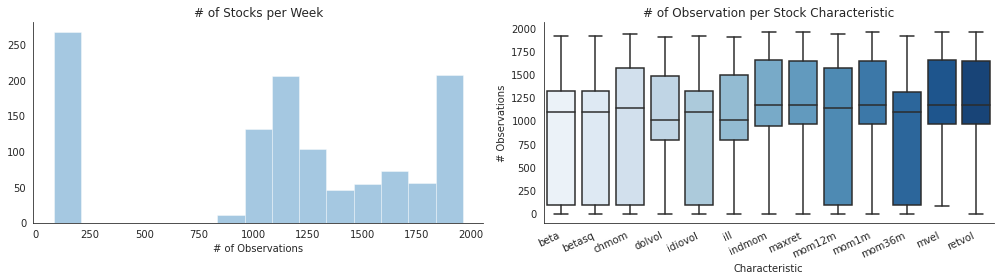

In [28]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()

### Rank-normalize characteristics

In [29]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [30]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2251228 entries, (Timestamp('2000-01-14 00:00:00', freq='W-FRI'), 'AAL') to (Timestamp('2022-01-07 00:00:00', freq='W-FRI'), 'ZYNE')
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      1285304 non-null  float64
 1   beta         986406 non-null   float64
 2   betasq       986406 non-null   float64
 3   chmom        1184968 non-null  float64
 4   dolvol       1142802 non-null  float64
 5   idiovol      986406 non-null   float64
 6   ill          1148128 non-null  float64
 7   indmom       1279314 non-null  float64
 8   maxret       1270146 non-null  float64
 9   mom12m       1184968 non-null  float64
 10  mom1m        1278156 non-null  float64
 11  mom36m       984680 non-null   float64
 12  mvel         1281806 non-null  float64
 13  retvol       1278156 non-null  float64
 14  returns_fwd  1285219 non-null  float64
dtypes: float64(15)
memory usage: 26

In [31]:
data.index.names

FrozenList(['date', 'ticker'])

In [32]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,returns_fwd
count,1.285304e+06,9.864060e+05,986406.000000,1.184968e+06,1.142802e+06,9.864060e+05,1.148128e+06,1.279314e+06,1.270146e+06,1.184968e+06,1.278156e+06,9.846800e+05,1.281806e+06,1.278156e+06,1.285219e+06
mean,3.649240e-03,-3.395821e-08,-0.000001,-3.187073e-08,-2.443282e-07,-5.318335e-07,-1.937938e-06,1.762229e-03,-4.982460e-07,-5.370746e-07,-6.787244e-09,-6.874396e-07,-2.435672e-07,-2.999413e-06,3.645127e-03
std,1.371731e-01,5.779312e-01,0.577933,5.778837e-01,5.779275e-01,5.779315e-01,5.779261e-01,6.167541e-01,5.778677e-01,5.778841e-01,5.778660e-01,5.779322e-01,5.778665e-01,5.778706e-01,1.371700e-01
min,-9.812491e-01,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.812491e-01
25%,-2.969524e-02,-5.003937e-01,-0.500380,-5.003085e-01,-5.004249e-01,-5.003776e-01,-5.003630e-01,-5.040816e-01,-5.003137e-01,-5.003257e-01,-5.003152e-01,-5.004232e-01,-5.003303e-01,-5.003434e-01,-2.969676e-02
50%,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.061224e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.111111e-02,5.004210e-01,0.500359,5.003475e-01,5.003924e-01,5.004070e-01,5.003389e-01,5.000000e-01,5.002912e-01,5.003100e-01,5.002747e-01,5.003579e-01,5.003578e-01,5.003041e-01,3.110728e-02
max,1.056657e+02,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.056657e+02


In [33]:
data = data.loc[idx[:'2019', :], :]

In [34]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [35]:
data = data.fillna(-2)

In [36]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [37]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [38]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [39]:
n_tickers

1961

In [40]:
n_characteristics

13

### Input Layer

In [41]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [42]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [43]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [44]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [45]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [46]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 1961, 13)]   0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 1961, 8)      112         ['input_beta[0][0]']             
                                                                                                  
 batch_norm (BatchNormalization  (None, 1961, 8)     32          ['hidden_layer[0][0]']           
 )                                                                                                
                                                                                                  
 input_factor (InputLayer)      [(None, 1961)]       0           []                           

## Train Model

### Cross-validation parameters

In [20]:
YEAR = 52

# kjp: changed `20*YEAR` to `train_yrs*YEAR` below
- there are **claimed** to be only 20 years worth of data
    - code below shows much less
    - due to cell above where data was truncated to year 2019
    
      `data = data.loc[idx[:'2019', :], :]`
- can't have train data of 20 years + test data of 1 year
- examine how MultipleTimeSeriesCV split data to determine best value to get 5 folds

In [49]:
print(f"Number of rows: {data.shape[0]}")
print(f"Num. unique tickers {data.index.get_level_values(1).unique().shape[0]}")
print(f"Num. unique dates {data.index.get_level_values(0).unique().shape[0]}")
print(f"\tmin date: {data.index.get_level_values(0).min()} , max date: {data.index.get_level_values(0).max()}")


Number of rows: 2043362
Num. unique tickers 1961
Num. unique dates 1042
	min date: 2000-01-14 00:00:00 , max date: 2019-12-27 00:00:00


In [21]:
# kjp: original code was constant 20 years
#      we calculate it based on data size
data_num_rows = data.shape[0]
data_num_tickers = data.index.get_level_values(1).unique().shape[0]
dates_per_ticker = data_num_rows/data_num_tickers
yrs_per_ticker   = round(dates_per_ticker/252 + 0.5)

train_yrs = yrs_per_ticker

print(f"Using {train_yrs} years of data for training fold.")

cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=train_yrs*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

Using 5 years of data for training fold.


# kjp: examine how folds are created by above MultipleTImeSeriesCV

In [51]:
print("Index of rows in each fold:\n")

for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
    train_start_idx, train_end_idx = train_idx[0], train_idx[-1]
    val_start_idx, val_end_idx = val_idx[0], val_idx[-1]
    
    train_len = (train_end_idx - train_start_idx +1)
    val_len   = (val_end_idx   - val_start_idx + 1)
    print(f"Fold {fold}, train idxs: {train_start_idx}:{train_end_idx} len {train_len}; val idxs: {val_start_idx}:{val_end_idx} len {val_len}")
    print(f"\ttrain: {data.iloc[train_idx].index.get_level_values(0).min()}: {data.iloc[train_idx].index.get_level_values(0).max()}")
    print(f"\tval  : {data.iloc[val_idx].index.get_level_values(0).min()}: {data.iloc[val_idx].index.get_level_values(0).max()}")

Index of rows in each fold:

Fold 0, train idxs: 1431530:1941389 len 509860; val idxs: 1941390:2043361 len 101972
	train: 2014-01-10 00:00:00: 2018-12-28 00:00:00
	val  : 2019-01-04 00:00:00: 2019-12-27 00:00:00
Fold 1, train idxs: 1329558:1839417 len 509860; val idxs: 1839418:1941389 len 101972
	train: 2013-01-11 00:00:00: 2017-12-29 00:00:00
	val  : 2018-01-05 00:00:00: 2018-12-28 00:00:00
Fold 2, train idxs: 1227586:1737445 len 509860; val idxs: 1737446:1839417 len 101972
	train: 2012-01-13 00:00:00: 2016-12-30 00:00:00
	val  : 2017-01-06 00:00:00: 2017-12-29 00:00:00
Fold 3, train idxs: 1125614:1635473 len 509860; val idxs: 1635474:1737445 len 101972
	train: 2011-01-14 00:00:00: 2016-01-01 00:00:00
	val  : 2016-01-08 00:00:00: 2016-12-30 00:00:00
Fold 4, train idxs: 1023642:1533501 len 509860; val idxs: 1533502:1635473 len 101972
	train: 2010-01-15 00:00:00: 2015-01-02 00:00:00
	val  : 2015-01-09 00:00:00: 2016-01-01 00:00:00


In [52]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [53]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [54]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [55]:
batch_size = 32

In [56]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [ ]:
start = time()
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val,
                                                             X2_val],
                                                            verbose=0).reshape(-1),
                                    'y_true': y_val.stack().values},
                                   index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')            
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

00:00:03 | 2 | 08 | 00-000 | -7.76% | -5.38% | -5.69%
00:00:41 | 2 | 08 | 00-050 | -0.91% | -0.69% | -0.14%
00:01:15 | 2 | 08 | 00-100 | -0.29% | -0.66% | -0.15%
00:01:51 | 2 | 08 | 00-150 |  0.57% | -0.74% | -0.47%
00:02:26 | 2 | 08 | 00-200 |  3.78% | -1.26% | -0.08%
00:03:01 | 2 | 08 | 01-000 |  7.96% |  0.14% |  1.17%
00:03:34 | 2 | 08 | 01-050 |  3.64% |  1.97% |  2.19%
00:04:08 | 2 | 08 | 01-100 |  1.92% | -0.15% |  0.69%
00:04:45 | 2 | 08 | 01-150 |  4.10% |  0.68% |  2.04%
00:05:26 | 2 | 08 | 01-200 |  4.23% |  0.51% |  1.28%
00:06:01 | 2 | 08 | 02-000 |  4.52% |  0.65% |  1.09%
00:06:37 | 2 | 08 | 02-050 |  2.43% | -0.05% | -0.25%
00:07:12 | 2 | 08 | 02-100 |  1.44% | -0.91% |  0.60%
00:07:46 | 2 | 08 | 02-150 |  0.43% |  0.23% |  0.76%
00:08:20 | 2 | 08 | 02-200 |  1.69% | -0.15% | -1.26%
00:08:55 | 2 | 08 | 03-000 |  4.70% |  1.42% |  1.00%
00:09:29 | 2 | 08 | 03-050 |  0.55% |  0.87% |  0.53%
00:10:02 | 2 | 08 | 03-100 |  4.64% |  1.89% |  0.28%
00:10:37 | 2 | 08 | 03-150 |

### Evaluate Results

In [10]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [11]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            10000 non-null  int64  
 1   n_factors        10000 non-null  int64  
 2   fold             10000 non-null  int64  
 3   epoch            10000 non-null  int64  
 4   ic_mean          10000 non-null  float64
 5   ic_daily_mean    10000 non-null  float64
 6   ic_daily_std     10000 non-null  float64
 7   ic_daily_median  10000 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 703.1 KB


In [12]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

<ipython-input-12-9bd6e27f2cfc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = (scores.groupby(['n_factors', 'units', 'epoch'])


In [13]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
1771,6,8,21,0.169272,0.066727,0.059590
1944,6,8,194,0.141035,0.049329,0.057136
1787,6,8,37,0.150284,0.056764,0.056860
1774,6,8,24,0.152279,0.062384,0.056746
1768,6,8,18,0.158619,0.061924,0.056302
1786,6,8,36,0.145308,0.061568,0.056033
1770,6,8,20,0.156049,0.059797,0.053323
1928,6,8,178,0.131247,0.049524,0.052764
1974,6,8,224,0.129432,0.045943,0.052561
1940,6,8,190,0.140694,0.050803,0.052341


In [14]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
6         8              6      8     21  0.169272       0.066727   
          8              6      8    194  0.141035       0.049329   
          8              6      8     37  0.150284       0.056764   
          8              6      8     24  0.152279       0.062384   
          8              6      8     18  0.158619       0.061924   

                 ic_daily_median  
n_factors units                   
6         8             0.059590  
          8             0.057136  
          8             0.056860  
          8             0.056746  
          8             0.056302

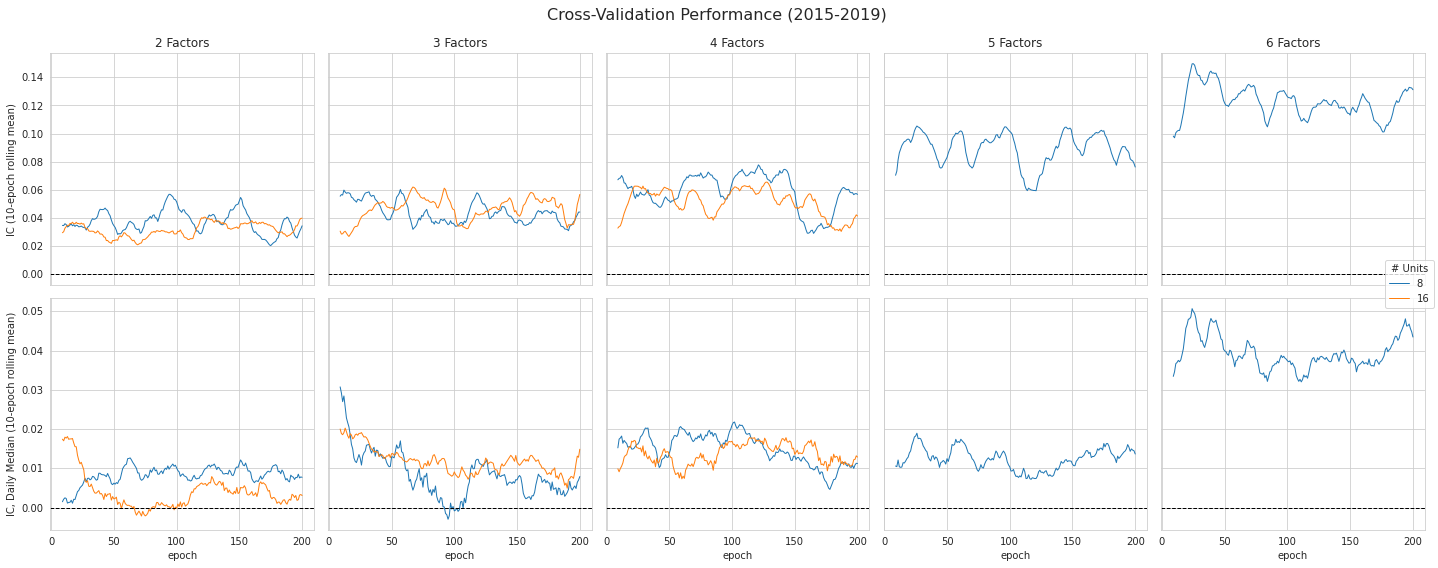

In [15]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [22]:
n_factors = 4
units = 32
batch_size = 32
first_epoch = 50
last_epoch = 80

In [23]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)

        model = make_model(n_factors=n_factors, hidden_units=units)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|          | 0/30 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [ ]:
predictions_combined.info()

In [ ]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')